In [1]:
%load_ext autoreload
%autoreload 2
from multiprocessing import Process, Queue, Event
from memex import set_voltage_4
from memex import vramp
from memex import sram
import numpy as np
import pandas as pd
import csv
import board
import RPi.GPIO as GPIO
import busio
import time

GPIO.setup(26, GPIO.OUT)
#toggle OE
def toggle_oe(state):
    if state == 1:
        GPIO.output(26, 1)
        
    else:
        GPIO.output(26, 0)

'''
variables
'''

#Name of the DUT
device = 'microchip'
path = '~/MemEx/data/sram/data_6-25/'
pattern = 0x55


Q = Queue()

'''
Initialize SRAM
'''
print('Initializing SRAMs...')
    
GPIO.setmode(GPIO.BCM)            # choose BCM or BOARD 

#set voltage for memory
set_voltage_4({'a':3.3})

#set OE high
toggle_oe(1)

#set hold pin high
GPIO.setup(19, GPIO.OUT) # set a port/pin as an output   
GPIO.output(19, 1)       # set port/pin value to 1/GPIO.HIGH/True  

spi = busio.SPI(board.SCLK,MOSI=board.MOSI,MISO=board.MISO)
spi.try_lock()
spi.configure(baudrate=1000000)
spi.unlock()

m1 = sram(spi,cs=board.D5, name="M1", size=32, bit_address=16) # init m1
m2 = sram(spi,cs=board.D6, name="M2", size=32, bit_address=16) # init m1
m3 = sram(spi,cs=board.D13, name="M3", size=32, bit_address=16) # init m1

Initializing SRAMs...


In [4]:
m2.write(0,70)
m2.read(0)

[70]

In [8]:
vramp(0, 3.3, step_size=2, channel = 'a')

0

In [2]:
import adafruit_ina219

def check_status(multiprocess = False,
                 sensor = adafruit_ina219.INA219(busio.I2C(board.SCL, board.SDA))):
    
    data = []
    t0 = time.time()
    i = 0
    print('taking data')
    while not quit.is_set():
        
        volt = sensor.bus_voltage
        current = sensor.current
        
        data.append([volt, current]) 
        
    
    print('data taking complete')
    
    df = pd.DataFrame(data, columns = ['Voltage','Current'])
    df = df.query('Current > 0.2')
    avg_current = df['Current'].mean()
    
    df1 = pd.DataFrame()
    
    df1[m1.name+'_'+time.ctime().split(' ')[3]] = [avg_current]
    
    if multiprocess:
        Q.put(df1)
        
def fill_mem(memory, pattern):
    memory.fill(pattern)
    foundit.set()

In [3]:
#open containing write, read, and leakage current
try:
    df_rwl = pd.read_csv(path+device+'_rwl.csv', index_col=[0,1])
except:
    arrays = [np.array(['microchip','microchip','microchip', 'on','on','on', 'issi','issi','issi', 
                    'cypress','cypress','cypress']),
    np.array(['Write Current [mA]', 'Read Current [mA]','Idle Current [mA]', 
            'Write Current [mA]', 'Read Current [mA]','Idle Current [mA]',
            'Write Current [mA]', 'Read Current [mA]','Idle Current [mA]',
            'Write Current [mA]', 'Read Current [mA]','Idle Current [mA]'])]

    c = pd.DataFrame(index=['Write Current [mA]', 'Read Current [mA]', 'Idle Current [mA]'])

    s = pd.DataFrame(index=arrays)
    df_rwl = pd.merge(s.reset_index(), c, left_on='level_1', right_index=True).groupby(['level_0', 'level_1']).sum()
    df_rwl.index.names = ['Manufacturer','Data']

for memory in [m1,m2,m3]:
    print('Filling to memory %s and sampling current'%(memory.name))
    
    data = Process(target=check_status, args=(True,))
    task = Process(target=fill_mem, args=(memory, pattern))

    quit = Event()
    foundit = Event()

    data.start()
    task.start()

    foundit.wait()
    quit.set()

    df_write = Q.get()

    current_column = df_write.columns[0]
    
    df_rwl.loc[(device, 'Write Current [mA]'), str(current_column)] = df_write.iloc[0][current_column]


Filling to memory M1 and sampling current
taking data
data taking complete
Filling to memory M2 and sampling current
taking data
data taking complete
Filling to memory M3 and sampling current
taking data
data taking complete


In [26]:
data = Process(target=check_status, args=(True,))
task = Process(target=fill_mem, args=(memory, pattern))

quit = Event()
foundit = Event()

data.start()
task.start()

foundit.wait()
quit.set()

df_write = Q.get()

In [11]:
import time


'15:37:43'

In [12]:
import pandas as pd
pd.read_csv('data/sram/data_6-25/microchip_PUF_15:39:08.csv')

,m1 TID @ 15:39:09,m2 TID @ 15:39:11,m3 TID @ 15:39:11,m1 TID @ 15:39:13,m2 TID @ 15:39:14,m3 TID @ 15:39:15,m1 TID @ 15:39:17,m2 TID @ 15:39:18,m3 TID @ 15:39:19,m1 TID @ 15:39:21,...,m3 TID @ 15:45:01,m1 TID @ 15:45:03,m2 TID @ 15:45:04,m3 TID @ 15:45:05,m1 TID @ 15:45:07,m2 TID @ 15:45:08,m3 TID @ 15:45:08,m1 TID @ 15:45:11,m2 TID @ 15:45:11,m3 TID @ 15:45:12
0,33,158,168,33,158,168,33,158,168,33,...,168,33,158,168,33,158,168,33,158,168
1,207,164,126,207,162,126,207,162,126,207,...,126,207,162,126,207,162,126,207,166,126
2,67,63,202,67,63,202,67,59,202,67,...,202,67,63,202,67,63,202,67,63,202
3,111,78,127,47,78,127,47,78,127,47,...,127,47,78,127,47,78,127,47,78,127
4,23,191,157,23,191,157,23,191,157,23,...,159,23,191,159,23,191,159,23,183,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32763,251,5,255,251,5,255,251,5,255,251,...,239,251,5,239,251,5,239,251,5,239
32764,191,246,151,191,254,151,191,254,151,62,...,151,63,254,151,63,254,151,63,254,151
32765,219,191,254,219,191,254,219,191,254,219,...,254,219,191,254,219,191,254,219,191,254
32766,154,255,89,155,255,89,155,255,89,155,...,89,155,255,89,155,255,89,155,255,89


In [13]:
pd.read_csv('data/sram/data_6-25/microchip_rwl.csv', index_col=[0,1])

M1_Jun 28 15:39:08 2021  \
Manufacturer Data                                          
microchip    Idle Current [mA]                  0.336985   
             Read Current [mA]                  2.243275   
             Write Current [mA]                 2.374179   
             Flipped bits                       0.000000   

                                 M2_Jun 28 15:39:08 2021  \
Manufacturer Data                                          
microchip    Idle Current [mA]                  0.336985   
             Read Current [mA]                  2.156192   
             Write Current [mA]                 2.176776   
             Flipped bits                       0.000000   

                                 M3_Jun 28 15:39:08 2021  
Manufacturer Data                                         
microchip    Idle Current [mA]                  0.336985  
             Read Current [mA]                  2.187211  
             Write Current [mA]                 2.172543  
             Flipped bits                       0.000000

In [164]:
arrays = [np.array(['microchip','microchip','microchip', 'on','on','on', 'issi','issi','issi', 
                    'cypress','cypress','cypress']),
          np.array(['Write Current', 'Read Current','Leakage Current [mA]', 
                    'Write Current', 'Read Current','Leakage Current [mA]',
                    'Write Current', 'Read Current','Leakage Current [mA]',
                    'Write Current', 'Read Current','Leakage Current [mA]'])]

c = pd.DataFrame(index=['Write Current [mA]', 'Read Current [mA]', 'Leakage Current [mA]'])

s = pd.DataFrame(index=arrays)
df = pd.merge(s.reset_index(), c, left_on='level_1', right_index=True).groupby(['level_0', 'level_1']).sum()
df.loc[('cypress', 'Leakage Current [mA]'), 'test'] = 10
df.to_csv('test.csv')
df1 = pd.read_csv('test.csv', index_col=[0,1])
df.index.names = ['Manufacturer','Data']
df

test
Manufacturer Data                      
cypress      Leakage Current [mA]  10.0
             Read Current [mA]      NaN
             Write Current [mA]     NaN
issi         Leakage Current [mA]   NaN
             Read Current [mA]      NaN
             Write Current [mA]     NaN
microchip    Leakage Current [mA]   NaN
             Read Current [mA]      NaN
             Write Current [mA]     NaN
on           Leakage Current [mA]   NaN
             Read Current [mA]      NaN
             Write Current [mA]     NaN

In [169]:
print('%s/%s'%('2','3'))

2/3


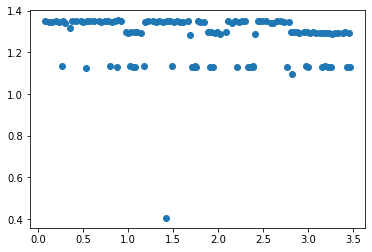

In [99]:
plt.scatter(df_write['Time'], df_write['Current'])

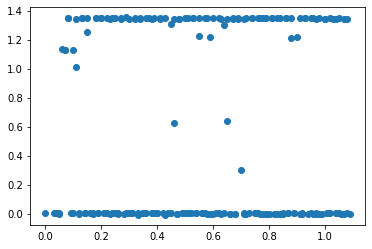

In [41]:
plt.scatter(df_write['Time'], df_write['Current'])

In [138]:
#PUF with vramp protocal:

for i in range(3):
    #bring voltage up slowly
    GPIO.output(26, 0)
    vramp(0, 3.3, step_size=2, channel = 'a')
    GPIO.output(26, 1)
    time.sleep(1)
    
    #read puf
    m1.save(file = "data/sram/puf_test_6-23/ISSIvramp%s.csv"%(str(i)))



Error in memex.set_voltage(): timed out


In [139]:
#PUF without vramp protocal:

for i in range(3):
    
    GPIO.output(26, 0)
    set_voltage_4({'a':0})
    time.sleep(0.5)
    set_voltage_4({'a':3.3})
    GPIO.output(26, 1)
    time.sleep(0.5)
    
    #read puf
    m1.save(file = "data/sram/puf_test_6-23/ISSIinstant%s.csv"%(str(i)))



Error in memex.set_voltage(): timed out
Error in memex.set_voltage(): timed out


In [48]:
from memex import check_status

ImportError: cannot import name 'check_status' from 'memex' (/home/pi/MemEx/memex.py)

In [26]:
import pandas as pd

data = m1.save_list()
        
df = pd.DataFrame()
df['TID @ '+time.ctime()[4::]] = data


,TID @ Jun 24 14:23:19 2021
0,85
1,85
2,85
3,85
4,85
...,...
131067,85
131068,85
131069,85
131070,85


## Microchip PUF analysis
With and without vramp

In [119]:
with open('data/sram/puf_test_6-23/MCinstant0.csv', newline='') as f:
    reader = csv.reader(f)
    data0 = list(reader)[0]

    for ii, byte in enumerate(data):

        data0[ii] = [int(i) for i in list(f'{int(data0[ii]):08b}')]
        
with open('data/sram/puf_test_6-23/MCinstant1.csv', newline='') as f:
    reader = csv.reader(f)
    data1 = list(reader)[0]

    for ii, byte in enumerate(data):

        data1[ii] = [int(i) for i in list(f'{int(data1[ii]):08b}')]
        
with open('data/sram/puf_test_6-23/MCinstant2.csv', newline='') as f:
    reader = csv.reader(f)
    data2 = list(reader)[0]

    for ii, byte in enumerate(data):

        data2[ii] = [int(i) for i in list(f'{int(data2[ii]):08b}')]

In [122]:
count01 = 0
count02 = 0
count12 = 0

for i in range(32768):
    for j in range(8):
        count01 += int(data0[i][j] != data1[i][j])
        count02 += int(data0[i][j] != data2[i][j])
        count12 += int(data1[i][j] != data2[i][j])
        
print("Microchip, instantly turning on SRAM:")
print("Threshold == "+str(32768/8))
print(count01, count02, count12)

Microchip, instantly turning on SRAM:
Threshold == 4096.0
9402 9041 9083


In [115]:
with open('data/sram/puf_test_6-23/MCvramp0.csv', newline='') as f:
    reader = csv.reader(f)
    data0r = list(reader)[0]

    for ii, byte in enumerate(data0r):

        data0r[ii] = [int(i) for i in list(f'{int(data0r[ii]):08b}')]
        
with open('data/sram/puf_test_6-23/MCvramp1.csv', newline='') as f:
    reader = csv.reader(f)
    data1r = list(reader)[0]

    for ii, byte in enumerate(data1r):

        data1r[ii] = [int(i) for i in list(f'{int(data1r[ii]):08b}')]
        
with open('data/sram/puf_test_6-23/MCvramp2.csv', newline='') as f:
    reader = csv.reader(f)
    data2r = list(reader)[0]

    for ii, byte in enumerate(data2r):

        data2r[ii] = [int(i) for i in list(f'{int(data2r[ii]):08b}')]

In [123]:
count01r = 0
count02r = 0
count12r = 0

for i in range(32768):
    for j in range(8):
        count01r += int(data0r[i][j] != data1r[i][j])
        count02r += int(data0r[i][j] != data2r[i][j])
        count12r += int(data1r[i][j] != data2r[i][j])

print("Microchip, vramp of ~2sec")
print("Threshold == "+str(32768/8))
print(count01r, count02r, count12r)

Microchip, vramp of ~2sec
Threshold == 4096.0
2228 3030 1502


# ON 16-bit Address PUF Analysis
With and without vramp

In [128]:
with open('data/sram/puf_test_6-23/ON16instant0.csv', newline='') as f:
    reader = csv.reader(f)
    ONdata0 = list(reader)[0]

    for ii, byte in enumerate(data):

        ONdata0[ii] = [int(i) for i in list(f'{int(ONdata0[ii]):08b}')]
        
with open('data/sram/puf_test_6-23/ON16instant1.csv', newline='') as f:
    reader = csv.reader(f)
    ONdata1 = list(reader)[0]

    for ii, byte in enumerate(data):

        ONdata1[ii] = [int(i) for i in list(f'{int(ONdata1[ii]):08b}')]
        
with open('data/sram/puf_test_6-23/ON16instant2.csv', newline='') as f:
    reader = csv.reader(f)
    ONdata2 = list(reader)[0]

    for ii, byte in enumerate(data):

        ONdata2[ii] = [int(i) for i in list(f'{int(ONdata2[ii]):08b}')]

In [129]:
ONcount01 = 0
ONcount02 = 0
ONcount12 = 0

for i in range(32768):
    for j in range(8):
        ONcount01 += int(ONdata0[i][j] != ONdata1[i][j])
        ONcount02 += int(ONdata0[i][j] != ONdata2[i][j])
        ONcount12 += int(ONdata1[i][j] != ONdata2[i][j])
        
print("ON 16-bit, instantly turning on SRAM:")
print("Threshold == "+str(32768/8))
print(ONcount01, ONcount02, ONcount12)

ON 16-bit, instantly turning on SRAM:
Threshold == 4096.0
9198 8940 8948


In [132]:
with open('data/sram/puf_test_6-23/ON16vramp0.csv', newline='') as f:
    reader = csv.reader(f)
    ONdata0r = list(reader)[0]

    for ii, byte in enumerate(data0r):

        ONdata0r[ii] = [int(i) for i in list(f'{int(ONdata0r[ii]):08b}')]
        
with open('data/sram/puf_test_6-23/ON16vramp1.csv', newline='') as f:
    reader = csv.reader(f)
    ONdata1r = list(reader)[0]

    for ii, byte in enumerate(data1r):

        ONdata1r[ii] = [int(i) for i in list(f'{int(ONdata1r[ii]):08b}')]
        
with open('data/sram/puf_test_6-23/ON16vramp2.csv', newline='') as f:
    reader = csv.reader(f)
    ONdata2r = list(reader)[0]

    for ii, byte in enumerate(data2r):

        ONdata2r[ii] = [int(i) for i in list(f'{int(ONdata2r[ii]):08b}')]

In [133]:
ONcount01r = 0
ONcount02r = 0
ONcount12r = 0

for i in range(32768):
    for j in range(8):
        ONcount01r += int(ONdata0r[i][j] != ONdata1r[i][j])
        ONcount02r += int(ONdata0r[i][j] != ONdata2r[i][j])
        ONcount12r += int(ONdata1r[i][j] != ONdata2r[i][j])

print("ON 16-bit, vramp of ~2sec")
print("Threshold == "+str(32768/8))
print(ONcount01r, ONcount02r, ONcount12r)

ON 16-bit, vramp of ~2sec
Threshold == 4096.0
7345 7679 6938


# ISSI 24-bit Address PUF Analysis
With and without vramp

In [140]:
with open('data/sram/puf_test_6-23/ISSIinstant0.csv', newline='') as f:
    reader = csv.reader(f)
    ISSIdata0 = list(reader)[0]

    for ii, byte in enumerate(data):

        ISSIdata0[ii] = [int(i) for i in list(f'{int(ISSIdata0[ii]):08b}')]
        
with open('data/sram/puf_test_6-23/ISSIinstant1.csv', newline='') as f:
    reader = csv.reader(f)
    ISSIdata1 = list(reader)[0]

    for ii, byte in enumerate(data):

        ISSIdata1[ii] = [int(i) for i in list(f'{int(ISSIdata1[ii]):08b}')]
        
with open('data/sram/puf_test_6-23/ISSIinstant2.csv', newline='') as f:
    reader = csv.reader(f)
    ISSIdata2 = list(reader)[0]

    for ii, byte in enumerate(data):

        ISSIdata2[ii] = [int(i) for i in list(f'{int(ISSIdata2[ii]):08b}')]

In [143]:
ISSIcount01 = 0
ISSIcount02 = 0
ISSIcount12 = 0

for i in range(32768):
    for j in range(8):
        ISSIcount01 += int(ISSIdata0[i][j] != ISSIdata1[i][j])
        ISSIcount02 += int(ISSIdata0[i][j] != ISSIdata2[i][j])
        ISSIcount12 += int(ISSIdata1[i][j] != ISSIdata2[i][j])
        
print("ISSI 24-bit, instantly turning on SRAM:")
print("Threshold == "+str(131072/8))
print(ISSIcount01, ISSIcount02, ISSIcount12)

ISSI 24-bit, instantly turning on SRAM:
Threshold == 16384.0
14336 13312 11264


In [144]:
with open('data/sram/puf_test_6-23/ISSIvramp0.csv', newline='') as f:
    reader = csv.reader(f)
    ISSIdata0r = list(reader)[0]

    for ii, byte in enumerate(data0r):

        ISSIdata0r[ii] = [int(i) for i in list(f'{int(ISSIdata0r[ii]):08b}')]
        
with open('data/sram/puf_test_6-23/ISSIvramp1.csv', newline='') as f:
    reader = csv.reader(f)
    ISSIdata1r = list(reader)[0]

    for ii, byte in enumerate(data1r):

        ISSIdata1r[ii] = [int(i) for i in list(f'{int(ISSIdata1r[ii]):08b}')]
        
with open('data/sram/puf_test_6-23/ISSIvramp2.csv', newline='') as f:
    reader = csv.reader(f)
    ISSIdata2r = list(reader)[0]

    for ii, byte in enumerate(data2r):

        ISSIdata2r[ii] = [int(i) for i in list(f'{int(ISSIdata2r[ii]):08b}')]

In [145]:
ISSIcount01r = 0
ISSIcount02r = 0
ISSIcount12r = 0

for i in range(32768):
    for j in range(8):
        ISSIcount01r += int(ISSIdata0r[i][j] != ISSIdata1r[i][j])
        ISSIcount02r += int(ISSIdata0r[i][j] != ISSIdata2r[i][j])
        ISSIcount12r += int(ISSIdata1r[i][j] != ISSIdata2r[i][j])

print("ISSI 24-bit, vramp of ~2sec")
print("Threshold == "+str(131072/8))
print(ISSIcount01r, ISSIcount02r, ISSIcount12r)

ISSI 24-bit, vramp of ~2sec
Threshold == 16384.0
13312 12288 9216
